<a href="https://colab.research.google.com/github/filopacio/_python_4_analytics_nlp_project/blob/main/ebola_vs_covid_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
Comparing and contrasting ebola and covid spreading of information on Twitter
---




This project is a NLP analysis of Twitter.

Tweets related to COVID and EBOLA have been analysed in order to find, if any, some patterns in the spreading of news. 

The research is mainly descriptive and focuses on two main different but actually interrelated themes: 

- Sentiment Analysis. 

Sentiments, initially labelled only as POSITIVE or NEGATIVE and then also analysed through more complex sentiments/emotions have been assigned to tweets and analysed. Also, sentiments' evolution through time has been investigated and how individual sentiments related to COVID and/or EBOLA change with respect to other topics.


- Use Of Keywords. 

Tweets have been processed in order to extrapolate the most commonly adopted words or expressions. The recurrence of words has been analysed also in relation to sentiment and time. 




In [ ]:
#!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip3 install -qq twint
!pip install nest_asyncio
!pip install transformers
!pip install text2emotion

     |████████████████████████████████| 1.3MB 37.1MB/s 
     |████████████████████████████████| 266kB 49.6MB/s 
     |████████████████████████████████| 358kB 50.9MB/s 
     |████████████████████████████████| 296kB 53.3MB/s 
     |████████████████████████████████| 143kB 58.3MB/s 
     |████████████████████████████████| 296kB 51.8MB/s 
     |████████████████████████████████| 2.5MB 28.4MB/s 
     |████████████████████████████████| 3.3MB 52.7MB/s 
     |████████████████████████████████| 901kB 52.2MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 133kB 41.0MB/s 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio
import twint 
from matplotlib import pyplot as plt

## Scrape tweets 

The package twint allows to scrape tweets without the need of API. 

Unfortunately the queries' commands were sometimes inconsistent and so some ex-post data selection and cleaning was necessary.

**Query for "covid"**


The period taken into consideration for COVID was from $1^{st}$ January 2020 to $30^{th}$ June 2021

In [ ]:
from datetime import datetime, timedelta

In [ ]:
d0 = datetime(2020, 1, 1)
d1 = datetime(2021, 6, 30)
dt = timedelta(days = 4)
dates = np.arange(d0, d1, dt).astype(datetime)

df_c = pd.DataFrame()

nest_asyncio.apply()
for i in dates:
  c = twint.Config()
  c.Search = 'covid'
  c.Until  = "{}".format(i)
  c.Lang = "en"
  c.Pandas = True
  c.Limit = 1000
  # Run
  twint.run.Search(c)
  df_c = df_c.append(twint.storage.panda.Tweets_df[['date', 'tweet','language' ,'username', 'nlikes', 'nretweets']])
  df_c.date = pd.to_datetime(df_c.date)
  df_c = df_c[df_c.language == 'en']
  df_c = df_c[df_c.date >= datetime(2020,1,1)]
  df_c.to_csv('df_c.csv')

In [ ]:
from google.colab import files

In [ ]:
files.download("df_c.csv")

**Query for "ebola"**

In [ ]:
d0 = datetime(2014, 7, 1)
d1 = datetime(2015, 5, 31)
dt = timedelta(days = 1)
dates = np.arange(d0, d1, dt).astype(datetime)

nest_asyncio.apply()
df_e = pd.DataFrame()
for i in dates:
  e = twint.Config()
  e.Search = 'ebola'
  e.Until  = "{}".format(i)
  e.Lang = "en"
  e.Pandas = True
  e.Limit = 1000
  # Run
  twint.run.Search(e)
  df_e = df_e.append(twint.storage.panda.Tweets_df[['date', 'tweet','language' ,'username', 'nlikes', 'nretweets']])
  df_e.date = pd.to_datetime(df_e.date)
  df_e = df_e[df_e.language == 'en']
  df_e = df_e[df_e.date >= datetime(2014,3,1)]
  df_e = df_e[df_e.date <= datetime(2015,5,31)]
  df_e.to_csv('df_e')

In [ ]:
files.download("df_e.csv")

Since both the queries are huge (millions of tweets) I  divided them into a  series of smaller queries for computational reason. I retrieved around 1000 tweets every 2 day inside the selected periods, so that the computation was not infeasible but still my sample was large and heterogenous enough. 


Also, some selection  and slicing of final data has been done while the loop was still running in order to reduce memory capacity and computational efforts. 


Finally, at every cycle of the loop I saved the resulting .csv file so that, in case of sudden stop of scraping, data up to that moment could be saved. 

Upload Datasets

In [7]:
import csv

In [8]:
with open('df_c.csv') as c:
    reader = csv.reader(c)
    l_c = list(reader)

df_c = pd.DataFrame(l_c, columns = ['','date', 'tweet','language' ,'username', 'nlikes', 'nretweets'])[1:].dropna()


In [ ]:
df_c.head()

In [19]:
with open("df_e.csv") as e:
    reader = csv.reader(e)
    l_e = list(reader)
    
df_e = pd.DataFrame(l_e, columns = ['','date', 'tweet','language' ,'username', 'nlikes', 'nretweets'])[1:].dropna()

In [ ]:
df_e.head()

## Sentiment Labelling

In [ ]:
from transformers import pipeline

The function "pipeline" in the package "transformers" automatically classifies the sentiment into POSITIVE or NEGATIVE categories, also giving the polarity of the sentiment on a scale from 0 to 1

**Polarity of each tweet**

In [ ]:
df_c = df_c[1:100]

In [ ]:
sentiment_classifier = pipeline('sentiment-analysis')

In [ ]:
sentiment_covid = sentiment_classifier(list(df_c.tweet)) 
sentiment_ebola = sentiment_classifier(list(df_e.tweet)) 

In [ ]:
df_c['sentiment'] = [sentiment_covid[i].get('label') for i in range(len(sentiment_covid))]
df_c['polarity'] =  [sentiment_covid[i].get('score') for i in range(len(sentiment_covid))]

In [ ]:
df_e['sentiment'] = [sentiment_covid[i].get('label') for i in range(len(sentiment_ebola))]
df_e['polarity'] =  [sentiment_covid[i].get('score') for i in range(len(sentiment_ebola))]

## Preprocessing


In [9]:
import re
import string
import nltk
from nltk.corpus import stopwords
from itertools import chain
from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Text Cleaning**

I created the clean_text function in order to clean the tweets from noisy characters. 

items removed: 
- links
- punctuations/special characters 
- emoticons

Before doing so I also put all the texts in lower case.
I did not remove alphanumeric words to avoid eliminating words like covid19, covid-19 etc.

In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https://\S+|www\.\S', '', text)      # remove link
    text = re.sub("['!@#$%^&*()_+<>?:.,;]" , '', text)  # punctuations/special characters
    text = re.sub(re.compile("["                        # emoticon
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
                           "]+", flags=re.UNICODE), '', text)
    return text

After being cleaned, each tweet is splitted into single words. 
Therefore, 'words' is a list of lists, where each element is a list of separated strings. 
Now, other pre-processing actions will be performed. 

**Stopwords removal**

What is considered a stopword can be found in the set  below. Such list belongs to the package nltk. 

In [ ]:
stopwords = set(stopwords.words('english')) 
stopwords

In [12]:
def remove_stopwords(text):
    stop = set(stopwords.words('english'))  
    stop.add('im')
    stop.add("i'm")
    stop.add('could')
    stop.add('go')
    stop.add('it')
    stop.add('get')
   # not present in the original set but very recurrent words
    text = [[i for i in i.split() if i not in stop] for i in text]
    return  text

**Lemmatization**

In [13]:
def lemmatize(text):
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(i, pos = 'v') for i in i] for i in text]
    return text

**Stemming**

In [14]:
def stem(text):
   stemmer = SnowballStemmer(language = 'english')
   text = [stemmer.stem(i) for i in text]
   return text

**Final outcome of preprocessing**

In [15]:
def preprocess(text):
  cl_tweets = [clean_text(c) for c in text]
  cl_tweets = pd.Series(cl_tweets).astype(str)
  removed = remove_stopwords(cl_tweets) 
  lemmatized = [lemmatize(i) for i in removed]
  stemmed = [stem(i) for i in lemmatized]
  return stemmed

In [16]:
from nltk.corpus import stopwords

In [17]:
df_c['tweets'] = preprocess(df_c.tweet)

In [20]:

df_e['tweets'] = preprocess(df_e.tweet)

## Analysis of keywords

In [ ]:
df_c_neg = df_c[df_c.sentiment == 'NEGATIVE'].reset_index()
df_c_pos = df_c[df_c.sentiment == 'POSITIVE'].reset_index()

In [ ]:
neg_w2v = Word2Vec(df_c_neg.tweets, min_count= 200)
neg_w2v.wv.vocab

In [ ]:
pos_w2v = Word2Vec(df_c_pos.tweets, min_count= 7)
pos_w2v.wv.vocab

**Word Embedding**

Word Embedding through a Principal Component Analysis Model

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot 

In [ ]:
covid_w2v = Word2Vec(df_c.tweets, min_count= 3000)
covid_w2v.wv.vocab

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


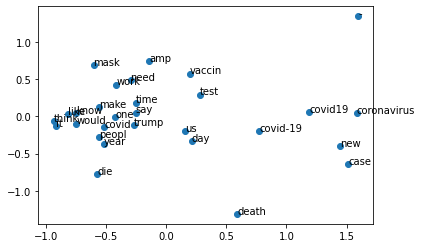

In [115]:
X = covid_w2v[covid_w2v.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(covid_w2v.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [118]:
ebola_w2v = Word2Vec(df_e.tweets, min_count= 2000)
ebola_w2v.wv.vocab

{'-': <gensim.models.keyedvectors.Vocab at 0x7f94ed40b1d0>,
 'africa': <gensim.models.keyedvectors.Vocab at 0x7f94ed408d50>,
 'case': <gensim.models.keyedvectors.Vocab at 0x7f94ed408790>,
 'dead': <gensim.models.keyedvectors.Vocab at 0x7f94ed408e10>,
 'death': <gensim.models.keyedvectors.Vocab at 0x7f94ed408250>,
 'ebola': <gensim.models.keyedvectors.Vocab at 0x7f94f6779ad0>,
 'fight': <gensim.models.keyedvectors.Vocab at 0x7f94ed40b610>,
 'guinea': <gensim.models.keyedvectors.Vocab at 0x7f94ed408910>,
 'health': <gensim.models.keyedvectors.Vocab at 0x7f94ed408150>,
 'leon': <gensim.models.keyedvectors.Vocab at 0x7f94ed4086d0>,
 'liberia': <gensim.models.keyedvectors.Vocab at 0x7f94ed408090>,
 'like': <gensim.models.keyedvectors.Vocab at 0x7f94ed3f3a10>,
 'new': <gensim.models.keyedvectors.Vocab at 0x7f94f6779cd0>,
 'news': <gensim.models.keyedvectors.Vocab at 0x7f94ed3f3f50>,
 'outbreak': <gensim.models.keyedvectors.Vocab at 0x7f94ed40b350>,
 'patient': <gensim.models.keyedvectors.Voc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


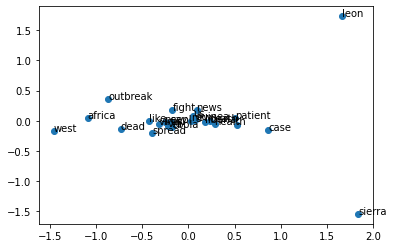

In [119]:
X = ebola_w2v[ebola_w2v.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(ebola_w2v.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

## Analysis of tweets per user

In this section, all the tweets of every user found in the first query are analyzed in order to identify relevant differences between the usual sentiment of its tweets and the one(s) related to the covid/ebola. 




I created two important functions in order to retrieve, again trough a twint query, the tweets of each user (with getTweets) and the ratio between that user's sentiment towards covid or ebola with respect to the other sentiment (with getSentiment).

e.g. 

user A shows 'NEGATIVE' sentiment in his covid related tweets.

getSentiment(user A , 'NEGATIVE') returns:

$ \frac { \# \ \ negative \ \  tweets } { \# \ \ positive \ \  tweets} $  



In [21]:
def getTweets(user):
  nest_asyncio.apply()
  u = twint.Config()
  u.Username = user 
  u.Pandas = True
  twint.run.Search(u)
  df_t = twint.storage.panda.Tweets_df
  return df_t

def getSentiment(user, covid_sentiment):
  df = getTweets(user)
  sentiment_classifier = pipeline('sentiment-analysis')
  sentiment_user = sentiment_classifier(list(df))
  sentiment =  [sentiment_user[i].get('label') for i in range(len(sentiment_user))]
  s = (sentiment == covid_sentiment).sum()/(sentiment != covid_sentiment).sum()
  return s

In [ ]:
df_c_neg['covid_vs_usual'] = [getSentiment(df_c_neg.username[i],df_c_neg.sentiment[i]) for i in range(len(df_c_neg.username))]
df_c_pos['covid_vs_usual'] = [getSentiment(df_c_pos.username[i],df_c_pos.sentiment[i]) for i in range(len(df_c_neg.username))]

In [ ]:
df_e_neg['ebola_vs_usual'] = [getSentiment(df_e_neg.username[i],df_e_pos.sentiment[i]) for i in range(len(df_e_neg.username))]
df_e_pos['ebola_vs_usual'] = [getSentiment(df_e_pos.username[i],df_e_pos.sentiment[i]) for i in range(len(df_e_neg.username))]

## Analysis vs Time

In this section 5 main periods are identified. 
Their labels are, obviously, broad approximations of reality that don't take into account singular states/regions/continents situations. 

- 1/01/2020 - 29/02/2020  : initial period, news spreading
- 1/03/2020 - 31/05/2020  : lockdown
- 1/06/2020 - 30/09/2020  : rules/laws softening
- 1/10/2020 - 31/01/2021  : new emergency
- 1/02/2021 - 30/06/2021  : vaccine campaigns

A sentiment analysis and a keywords analysis based on those 5 periods is performed in order to evaluate relevant differences. 


**Sentiment**

text2emotion is a package trough which more articulated sentiments can be obtained. In particular, the emotions of:

- Anger
- Fear
- Happyness
- Sadness
- Surprise

are recognised and assigned a number from 0 to 1 based on the polarity of the emotion. 


In [ ]:
# describe how POS and NEG sentiment are distributed among the periods.

In [24]:
import text2emotion as te

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The function getEmotion returns the emotion with highest polarity, where polarities are given by the function get_emotion() from the package 'text2emotion'.

However, since max returns only one argument and polarities may be equal, a different result is obtained only in the case in which Happyness and Sadness have equal polarity. I have done so because choosing either Happy or Sad emotion actually change significantly the result, and so a more general 'Mixed Emotion' label is assigned. I don't think that the other emotions have so opposite interpretation to deserve the same treatment. 



In [ ]:
def getEmotion(tweet):
  e = te.get_emotion(tweet)
  if e.get('Happy') == e.get('Sad'):
    r = 'Mixed Emotion'
  else:
    r = max(e, key = e.get)
  return r 

In [ ]:
df_c['emotion'] = [getEmotion(i) for i in df_c.tweet]

In [ ]:
df_e['emotion'] = [getEmotion(i) for i in df_e.tweet]

**Keywords**

In [ ]:
# describe the distribution and the intensity of words among periods.

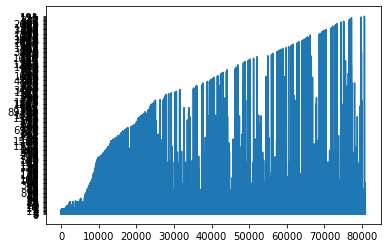

In [56]:
plt.plot(df_c.nretweets)

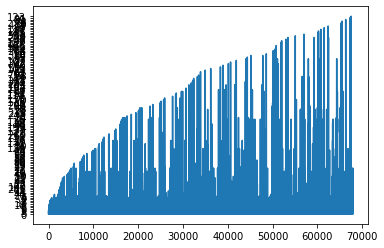

In [55]:
plt.plot(df_e.nretweets)

The graphs may suggest an important increase in popularity with respect to time, since the number of retweets for ebola-related and covid-related tweets increase with time.